In [ ]:
%matplotlib inline
%load_ext watermark
%watermark -a 'Arttu Modig' -v -m -d -t -p numpy,pandas,seaborn,matplotlib,pystan,notebook

Arttu Modig 2017-08-22 15:15:41 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
seaborn 0.8.0
matplotlib 2.0.2
pystan 2.16.0.1dev
notebook 5.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan

In [ ]:
%pwd

'/Users/amodig/git/R/stan'

In [ ]:
data = pd.read_csv("data_sales_grouped.csv")

In [ ]:
data.head()

,group,revenue,count,label
0,control,0.0,38314,1
1,control,1.0,4596,1
2,control,1.1,118,1
3,control,1.2,245,1
4,control,1.3,155,1


### Legacy model for A/B testing

In [ ]:
!cat legacy_updated.stan

data {
  int<lower=0> N;
  vector[N] y;
  int<lower=0, upper=2> x[N];  // bernoulli outcome
  vector[N] count;
}
transformed data {
}
parameters {
  vector[2] mu;
  vector<lower=0, upper=10>[2] sigma;  // lognormal sigma
  vector<lower=0, upper=1>[2] theta;  // bernoulli prob
}
model {
  mu ~ normal(2, 10);

  for (n in 1:N) {
    if (y[n] > 0)
      target += count[n] * (bernoulli_lpmf(0 | theta[x[n]])
                        + lognormal_lpdf(y[n] | mu[x[n]], sigma[x[n]]));
    else
      target += count[n] * bernoulli_lpmf(1 | theta[x[n]]);
  }
}
generated quantities {
  real pctrl ;
  real test ;

  // mean of log-normal distribution
  pctrl = exp(mu[1] + 0.5 * sigma[1] * sigma[1]);
  test = exp(mu[2] + 0.5 * sigma[2] * sigma[2]);
}


In [ ]:
iterations = 10000
chains = 8
iterations_total = iterations * chains

model_data = {"N": data.shape[0],
              "y": data['revenue'].astype(float).values,
              "x": data['label'].astype(int).values,
              "count": data['count'].astype(int).values}

fit = pystan.stan(file="legacy_updated.stan", model_name="legacy",
                  data=model_data, iter=iterations, chains=chains,
                  n_jobs=-1, verbose=True)

theta_0 = fit.extract()['theta'][:,0]
theta_1 = fit.extract()['theta'][:,1]
conversion_0 = 1 - theta_0
conversion_1 = 1 - theta_1
k0 = np.round(np.average(conversion_0) * 100, decimals=1)
k1 = np.round(np.average(conversion_1) * 100, decimals=1)
ctrl_revenue = fit.extract()['pctrl'] * conversion_0
test_revenue = fit.extract()['test'] * conversion_1

# collect results
results_all = {}
results_all['n'] = data['count'].sum()
results_all['test_revenue'] = test_revenue
results_all['ctrl_revenue'] = ctrl_revenue
results_all['k0'] = k0
results_all['k1'] = k1

INFO:pystan:COMPILING THE C++ CODE FOR MODEL legacy_29467b2cb2e4729c84d332a69caf73c9 NOW.
INFO:pystan:OS: darwin, Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.26


Compiling /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_8450968173468185260.pyx because it changed.
[1/1] Cythonizing /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_8450968173468185260.pyx
building 'stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_8450968173468185260' extension
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var/folders
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var/folders/86
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpwbzu5vo9/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpw

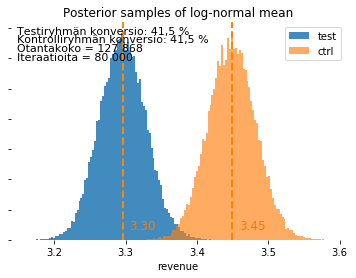

In [ ]:
fig, ax = plt.subplots()

ax.hist((test_revenue), bins=100, alpha=0.85, label="test")
ax.hist((ctrl_revenue), bins=100, alpha=0.65, label="ctrl")

ax.set_title("Posterior samples of log-normal mean")
plt.axvline(test_revenue.mean(), color='#FF8400', linestyle='dashed', linewidth=2)
plt.axvline(ctrl_revenue.mean(), color='#FF8400', linestyle='dashed', linewidth=2)
ax.set_yticklabels([])
ax.set_xlabel("revenue")
ax.legend()
x_axis = ax.get_xlim()[1] - ax.get_xlim()[0]
y_axis = ax.get_ylim()[1] - ax.get_ylim()[0]
width = plt.xlim()[0] + (x_axis * 0.02)
height = ax.get_ylim()[1]
font_height = y_axis * 0.04
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.text(width, height - font_height*1.3, 'Testiryhmän konversio: {} %'.format(k1).replace('.', ','), fontsize=11)
ax.text(width, height - font_height*2.3, 'Kontrolliryhmän konversio: {} %'.format(k0).replace('.', ','), fontsize=11)
ax.text(width, height - font_height*3.3, 'Otantakoko = {0:,}'.format(data['count'].sum()).replace(',', ' '), fontsize=11)    
ax.text(width, height - font_height*4.3, 'Iteraatioita = {0:,}'.format(iterations_total).replace(',', ' '), fontsize=11)
ax.text(test_revenue.mean()+0.02*x_axis, 0.05*height, '{0:.2f}'.format(test_revenue.mean()), color='#ff7700', fontsize=12)
ax.text(ctrl_revenue.mean()+0.02*x_axis, 0.05*height, '{0:.2f}'.format(ctrl_revenue.mean()), color='#ff7700', fontsize=12)

### New model for A/B/C/D/etc. testing

In [ ]:
!cat hier2.stan

functions {
  real lognormal_mean(real mu, real sigma) {
    return exp(mu + 0.5 * sigma * sigma);
  }
  real lognormal_sd(real mu, real sigma) {
    real a;
    real b;
    a = exp(sigma * sigma) - 1;
    b = exp(2 * mu + sigma * sigma);
    return sqrt(a * b); // sqrt of variance
  }
}
data {
  // notice we use grouped data per outcome value
  int<lower=0> N; // sum of unique outcomes
  int<lower=0> J; // number of test groups
  real<lower=0> y[N]; // observed outcome i.e. revenue
  int<lower=1> id[N]; // label for each unique outcome
  int<lower=1> count[N]; // count of each unique outcome
  real<lower=0> mean_log_y; // mean of log-positive outcomes
  real<lower=0> sd_log_y; // sd of log-positive outcomes
}
parameters {
  vector<lower=0, upper=1>[J] theta; // chance of success per test group, i.e. conversion rates per test group
  real<lower=0, upper=1> phi; // overall population chance of success
  real<lower=1> kappa; // population concentration
  vector<lower=0>[J] mu; // mu for 

In [ ]:
iterations = 10000
chains = 8
iterations_total = iterations * chains

rev = data['revenue']
rev = rev[rev > 0]
mean_log_y = np.mean(np.log(rev))
sd_log_y = np.std(np.log(rev))

model_data = {"N": data.shape[0],
            "J": data['label'].nunique(),
            "y": data['revenue'].astype(float).values,
            "id": data['label'].astype(int).values,  # id should start from 1!
            "count": data['count'].astype(int).values,
            "mean_log_y": mean_log_y,
            "sd_log_y": sd_log_y}

sm = pystan.StanModel(file="hier2.stan", verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b561a9ce0731c106ec388f0ec224ef0f NOW.
INFO:pystan:OS: darwin, Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.26


Compiling /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/stanfit4anon_model_b561a9ce0731c106ec388f0ec224ef0f_2235254929254327196.pyx because it changed.
[1/1] Cythonizing /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/stanfit4anon_model_b561a9ce0731c106ec388f0ec224ef0f_2235254929254327196.pyx
building 'stanfit4anon_model_b561a9ce0731c106ec388f0ec224ef0f_2235254929254327196' extension
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var/folders
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var/folders/86
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpcgkgcap3/var/folders/86/339xc0ws0nb5dtltnvzh88dw0

In [ ]:
# WTF Y U NOT WORK??
fit = sm.sampling(data=model_data, iter=iterations, chains=1, n_jobs=1, verbose=True,
                  control={'adapt_delta': 0.99, 'max_treedepth': 10})